In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
figsize(10, 8)

In [4]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [5]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [6]:
rc = 335.7133441444117
dc = 63.43802542905474

In [12]:
def calculate_sflux(bank='A', session='5', doplot=True, pixbeam=1., smth=0., removeplane=False):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * (~innerregion.flatten()) * (~outerregion.flatten())
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        signal = gaussian_filter(signal, smth/pixbeam)
        shits = gaussian_filter(hits, smth/pixbeam)
        #mask = shits == 0
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy/pixel]')
        title('Bank '+bank)
        #savefig('figures/map'+bank+session+'gradientremoved_smoothed.pdf', format='pdf')

    print np.nansum(signal[innerregion])
    return signal, rabins, decbins, innerregion, outerregion

38.1918970118


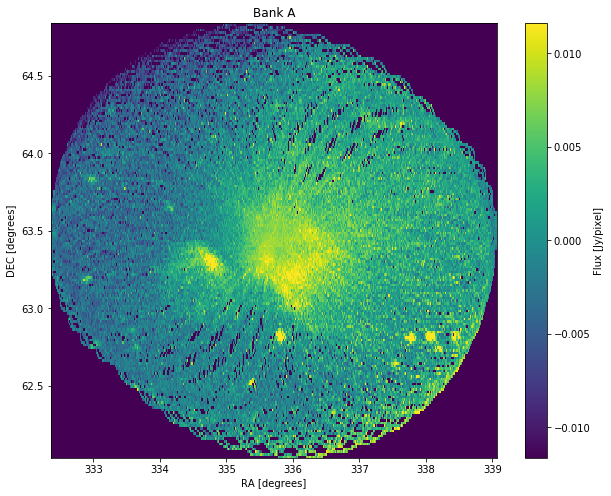

In [32]:
signal, rabins, decbins, innerregion, outerregion = calculate_sflux('A', '5', removeplane=True)

In [33]:
rabinsc = (rabins[1:] + rabins[:-1]) / 2.
decbinsc = (decbins[1:] + decbins[:-1]) / 2.

In [34]:
rdmesh = meshgrid(rabinsc, decbinsc)
radius_grid = np.sqrt( (rdmesh[0] - rc)**2 + (rdmesh[1] - dc)**2 ) 

In [35]:
rsig = signal.reshape(signal.size, )
radius = radius_grid.reshape(signal.size, )
x = zip(radius, rsig)
x.sort()
radsort, fluxsort = zip(*x)
radsort = np.array(radsort)
fluxsort = np.array(fluxsort)

In [36]:
mask = ~np.isnan(fluxsort)
rflux = np.cumsum(fluxsort[mask])

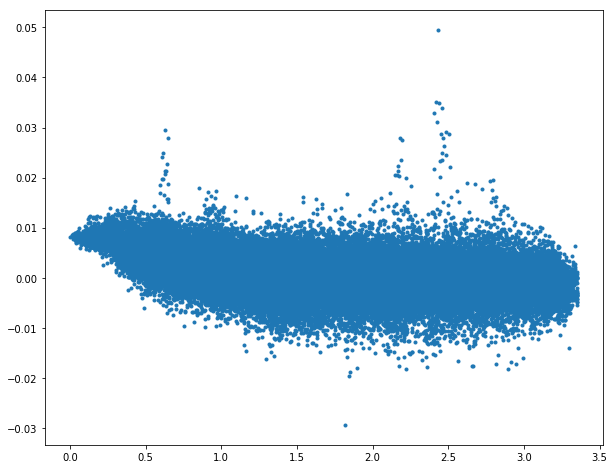

In [75]:
plot(radius, rsig, '.')

(0, 3.5)

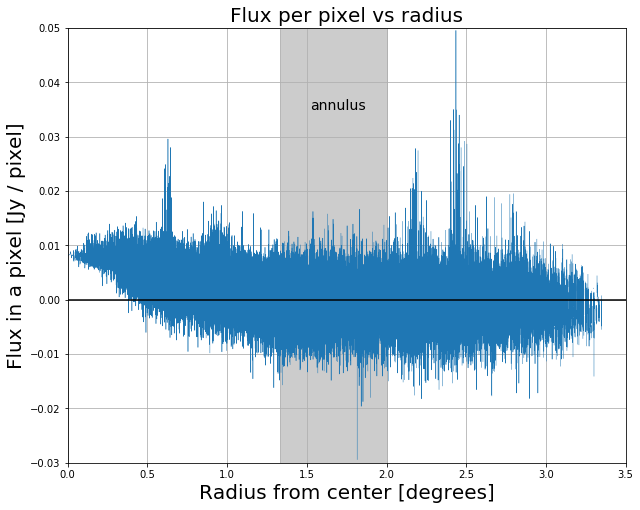

In [84]:
plot(radsort, fluxsort, lw=0.5)
grid()
xlabel('Radius from center [degrees]', fontsize=20)
ylabel('Flux in a pixel [Jy / pixel]', fontsize=20)
title('Flux per pixel vs radius', fontsize=20)
axhline(0, color='k')
ylim(-0.03, 0.05)
axvspan(4./3, 2., color='k', alpha=0.2)
text(1.52, 0.035, 'annulus', fontsize=14)
xlim(0, 3.5)
#savefig('figures/fluxperpixelvsradius')

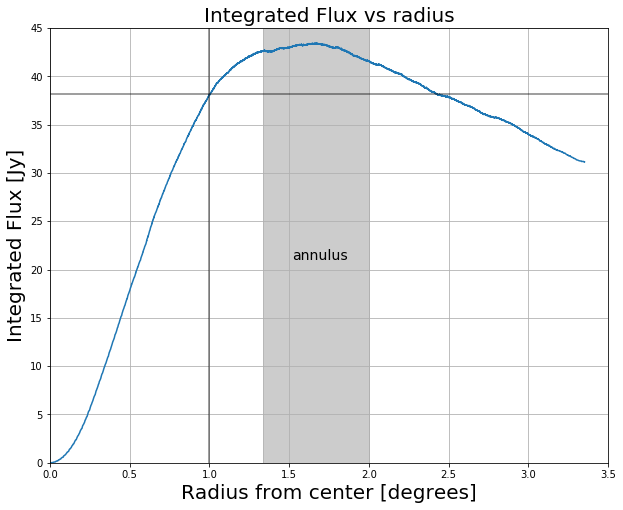

In [79]:
plot(radsort[mask], rflux)
grid()
xlabel('Radius from center [degrees]', fontsize=20)
ylabel('Integrated Flux [Jy]', fontsize=20)
title('Integrated Flux vs radius', fontsize=20)
axvline(1., color='k', alpha=0.5)
axhline(38.19, color='k', alpha=0.5)
axvspan(4./3, 2., color='k', alpha=0.2)
text(1.52, 21, 'annulus', fontsize=14)
ylim(0, 45)
xlim(0, 3.5)
savefig('figures/integratedfluxvsradius')